In [1]:
import numpy as np
import pandas as pd
import cudf

In [2]:
from typing import Union

import numpy as np
from sklearn.metrics import average_precision_score, mean_squared_error

def rmse(y_true: Union[np.ndarray, list], y_pred: Union[np.ndarray, list]) -> float:
    return np.sqrt(mean_squared_error(y_true, y_pred))


def rmsle(y_true: Union[np.ndarray, list], y_pred: Union[np.ndarray, list]) -> float:
    return rmse(np.log1p(y_true), np.log1p(y_pred))

In [3]:
y = pd.read_feather("../input/train.ftr")["Global_Sales"]

In [4]:
preds = [
    "036_use_top_10_seed_average/seed_054",
    "034_seed_average_033/seed_028",
    "036_use_top_10_seed_average/seed_017",
]

In [5]:
oof_preds = []
test_preds = []
for pred in preds:
    oof_preds.append(np.load("../output/" + pred + "/oof_preds.npy"))
    test_preds.append(np.load("../output/" + pred + "/test_preds.npy"))

In [6]:
oof_preds

[array([83.30832943, 94.20234028, 35.19430399, ...,  3.22761848,
        49.31173758, 25.47016217]),
 array([72.85822583, 66.28794095, 30.09998884, ...,  3.3797114 ,
        29.77360796, 17.9052972 ]),
 array([76.87703819, 86.44251429, 39.49909549, ...,  3.70552583,
        62.51884731, 25.63440797])]

In [7]:
rmsle(y, np.mean(oof_preds, axis=0))

0.9928239072879251

In [8]:
sample_submission = pd.read_csv("../input/sample_submission.csv")

In [9]:
sample_submission["Global_Sales"]=np.mean(test_preds, axis=0)

In [10]:
sample_submission.to_csv("../output/average_submission_3.csv", index=False)

In [11]:
def loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = 0
    for weight, oof_pred in zip(weights, oof_preds):
            final_prediction += weight*oof_pred

    return rmsle(y, final_prediction)

In [12]:
starting_values = [0.5]*len(oof_preds)

In [13]:
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})

In [14]:
from scipy.optimize import minimize

In [15]:
bounds = [(0,1)]*len(oof_preds)

In [16]:
res = minimize(loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

In [17]:
res["fun"]

0.9915601373498373

<AxesSubplot:>

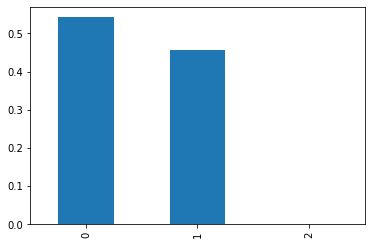

In [18]:
pd.Series(res["x"]).plot.bar()

In [19]:
final_prediction = 0
for weight, test_pred in zip(res["x"], test_preds):
        final_prediction += weight*test_pred

In [20]:
sample_submission["Global_Sales"]=final_prediction

In [21]:
sample_submission.to_csv("../output/slsqp_weight_average_submission_3.csv", index=False)